# Selekcja cech i redukcja wymiarowości

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo Seaborn dla wizualizacji.

**Uwaga:** upewnij się, że masz scikit-learn w wersji 1.2 lub nowszej (druga komórka poniżej). Dzięki temu będzie można ustawić opcję `transform_output="pandas"`, dzięki której wszystkie transformatory w scikit-learn będą nie tylko przyjmować, ale też zwracać DataFrame, zachowując nazwy zmiennych. Będzie to bardzo przydatne w analizie danych.

In [1]:
# !pip install numpy scipy pandas matplotlib scikit-learn missingno seaborn

In [2]:
# !pip install -U scikit-learn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza cech

Ponownie wykorzystamy zbiór danych [Ames housing](https://www.openintro.org/book/statdata/?data=ames), w którym zadaniem jest przewidywanie wartości domu na podstawie cech budynku, działki, lokalizacji itp. Ma on duży zbiór wejściowych cech, odpowiadający typowym wartościom ze stron handlujących nieruchomościami, więc odpowiada realnym potrzebom analizy biznesowej.

Interpretowalność jest tutaj kluczowa, bo każdy sprzedający chce zyskać jak najwięcej. Informacja, które cechy nie mają znaczenia dla kupujących, a na które jest zwracana największa uwaga, mogą np. pokierować decyzjami, które części domu wyremontować przed ogłoszeniem sprzedaży. Z kolei cechy o niskiej ważności warto odrzucić nie tylko, aby pomóc modelowi ML, ale też żeby np. nie wspominać o tych elementach w ogłoszeniu, bo i tak mało kogo obchodzą.

Zmniejszenie liczby cech jest też korzystne dla samych firm IT oferujących serwisy sprzedażowe, bo może być ważne dla user experience (UX). Formularz na 70 elementów o różnych cechach domu jest mocno problematyczny do wypełnienia, a taki na 20 jest już znacznie przyjaźniejszy. Takie rzeczy jak najbardziej mogą decydować o tym, którą platformę do ogłoszeń wybiorą sprzedający.

Poniższy kod wczytuje dane i dokonuje podziału na zbiór treningowy i testowy.

**Uwaga:** będziemy operować na wielu kopiach danych do różnych wariantów procesowania danych. Nadpisanie zmiennej `X_train` z komórki poniżej może skutkować trudnymi do znalezienia bugami, zwróć na to uwagę.

In [5]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("ames_data.csv")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

df = df.loc[df["GrLivArea"] <= 4000, :]

df.loc[:, "SalePrice"] = np.log1p(df.loc[:, "SalePrice"])


def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# Electrical : NA most likely means standard
replace_na(df, "Electrical", value="SBrkr")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

y = df.pop("SalePrice")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2500,SC60,RL,105.0,11025,2,0,4,HLS,4,Inside,...,0,0,0,No,No,0,Oct,2006,WD,Normal
261,SC20,RL,75.0,10650,2,0,4,Lvl,4,Corner,...,0,0,0,MnPrv,No,0,Feb,2010,WD,Normal
1774,SC60,RL,82.0,9044,2,0,3,Lvl,4,Inside,...,0,0,0,No,No,0,May,2007,WD,Normal
2588,SC20,RL,80.0,13600,2,0,4,Bnk,4,Inside,...,0,0,0,MnPrv,Shed,650,Nov,2006,WD,Normal
1023,SC20,RL,90.0,13068,2,0,4,Lvl,4,Corner,...,0,0,0,MnPrv,No,0,Nov,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,SC90,RL,60.0,10800,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Mar,2009,WD,Alloca
835,SC20,RL,82.0,12464,2,0,2,Low,4,Corner,...,0,0,0,GdPrv,No,0,Nov,2009,WD,Normal
1654,SC20,RL,80.0,10400,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Aug,2007,WD,Normal
2613,SC20,RL,60.0,7332,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Oct,2006,WD,Abnorml


Analiza cech kategorycznych i numerycznych wykorzystuje często różne metody i wymaga innego preprocessingu. Dodatkowo one-hot encoding bardzo utrudnia interpretację cech kategorycznych, dlatego trzeba się zastanowić, na którym etapie przetwarzania danych dokonujemy sprawdzania ważności cech danym algorytmem.

Na początek skupimy się na zmiennych numerycznych. Podstawową metodą jest sprawdzenie wariancji tych danych. Wymaga to danych bez wartości brakujących i o tej samej skali.

**Uwaga:** nie można tutaj dokonać standaryzacji! Wtedy dzieli się przez odchylenie standardowe, więc wszystko ma wariancję 1. Trzeba dokonać przeskalowania przez min-max scaling.

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


X_train_num = X_train.select_dtypes(exclude="object")

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

X_train_num = numerical_pipeline.fit_transform(X_train_num)
X_train_num

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
2500,0.335463,0.044697,1.0,0.0,1.000000,1.0,0.5,0.777778,0.500,0.868217,...,1.0,0.124298,0.280323,0.183794,0.00000,0.0,0.0,0.0,0.000,0.00
261,0.239617,0.042942,1.0,0.0,1.000000,1.0,1.0,0.444444,0.625,0.744186,...,1.0,0.256320,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,1.00
1774,0.261981,0.035430,1.0,0.0,0.666667,1.0,1.0,0.777778,0.500,0.899225,...,1.0,0.139045,0.123989,0.000000,0.00000,0.0,0.0,0.0,0.000,0.25
2588,0.255591,0.056742,1.0,0.0,1.000000,1.0,1.0,0.444444,0.625,0.581395,...,1.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.052,0.00
1023,0.287540,0.054253,1.0,0.0,1.000000,1.0,1.0,0.555556,0.500,0.744186,...,1.0,0.000000,0.000000,0.000000,0.34252,0.0,0.0,0.0,0.000,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.191693,0.043644,1.0,0.0,1.000000,1.0,1.0,0.444444,0.500,0.829457,...,1.0,0.084270,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.75
835,0.261981,0.051428,1.0,0.0,0.333333,1.0,0.5,0.444444,0.500,0.899225,...,1.0,0.117978,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.75
1654,0.255591,0.041773,1.0,0.0,1.000000,1.0,1.0,0.555556,0.500,0.767442,...,1.0,0.168539,0.190027,0.000000,0.00000,0.0,0.0,0.0,0.000,0.25
2613,0.191693,0.027421,1.0,0.0,1.000000,1.0,1.0,0.555556,0.625,0.612403,...,1.0,0.117978,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.00


Do usuwania cech o niskiej wariancji służy klasa `VarianceThreshold`. Jaki jednak ustawić próg wariancji? To dobrze byłoby najpierw sprawdzić na wykresie, bo w zależności od zbioru dane po prostu ogólnie mogą mieć mniejszą lub większą zmienność.

**Zadanie 1 (0.5 punktu)**

1. Oblicz wariancję dla cech w danych treningowych.
2. Posortuj cechy w kolejności od największej do najmniejszej wariancji.
3. Wypisz cechy o najmniejszej wariancji (razem z jej wartościami).
4. Przedstaw to na wykresie słupkowym (bar plot). Pamiętaj o tytule wykresu, opisaniu osi i cech. Upewnij się, że ma odpowiednią wielkość, aby nazwy cech były czytelne.
5. Zinterpretuj wykres i skomentuj:
   - jaki twoim zdaniem byłby sensowny próg wariancji?
   - czy jest cecha / cechy, które twoim zdaniem są tak mało zmienne, że są bezużyteczne?
   - czy twoim zdaniem cechy o największej wariancji wydają się bardzo użyteczne?

Podpowiedź: każdy z podpunktów da się zrobić jedną metodą na DataFrame'ie.

<ipython-input-15-a7b0d5c517c8>:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variance = X_train.var()


GarageQual      0.484293
GarageCond      0.475700
Functional      0.454647
KitchenQual     0.444601
Fireplaces      0.420058
ExterQual       0.341383
BsmtCond        0.323722
LotShape        0.317708
FullBath        0.302218
BsmtFullBath    0.271854
PavedDrive      0.269716
HalfBath        0.250488
ExterCond       0.137746
Alley           0.133423
LandSlope       0.063427
BsmtHalfBath    0.059373
KitchenAbvGr    0.043518
PoolQC          0.021465
Street          0.003899
Utilities       0.002444
dtype: float64


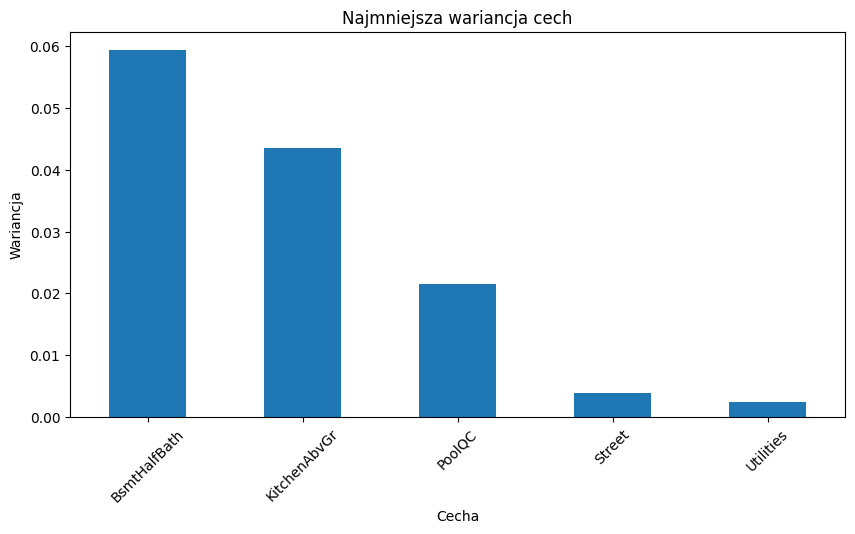

In [15]:
# Obliczanie wariancji dla cech w danych treningowych
variance = X_train.var()

# Sortowanie cech w kolejności malejącej
sorted_variance = variance.sort_values(ascending=False)

# Wypisanie cech o najmniejszej wariancji
lowest_variance = sorted_variance.tail()

print(sorted_variance[-20:])

# Wykres słupkowy cech o najmniejszej wariancji
plt.figure(figsize=(10, 5))
lowest_variance.plot(kind="bar")
plt.title("Najmniejsza wariancja cech")
plt.xlabel("Cecha")
plt.ylabel("Wariancja")
plt.xticks(rotation=45)
plt.show()

##Komentarz

Przyjęcie progu wariancji w okolicach wartości 0.35 wydaje się rozsądne, ponieważ umożliwia skuteczną eliminację nieistotnych cech, które często są powszechne i mało znaczące dla większości domów, takie jak na przykład rodzaj drogi dojazdowej, alejka czy nachylenie terenu.

Wariancja sprawdza tylko zmienność cech, a w szczególności nie uwzględnia żadnych interakcji między cechami. Sprawdźmy zatem liniowe korelacje pomiędzy cechami.

Jako że naszych cech jest bardzo dużo, to najpier warto narysować heatmapę korelacji, bez żadnych liczb, i wizualnie oszacować, czy mamy mocno skorelowane cechy.

<Axes: >

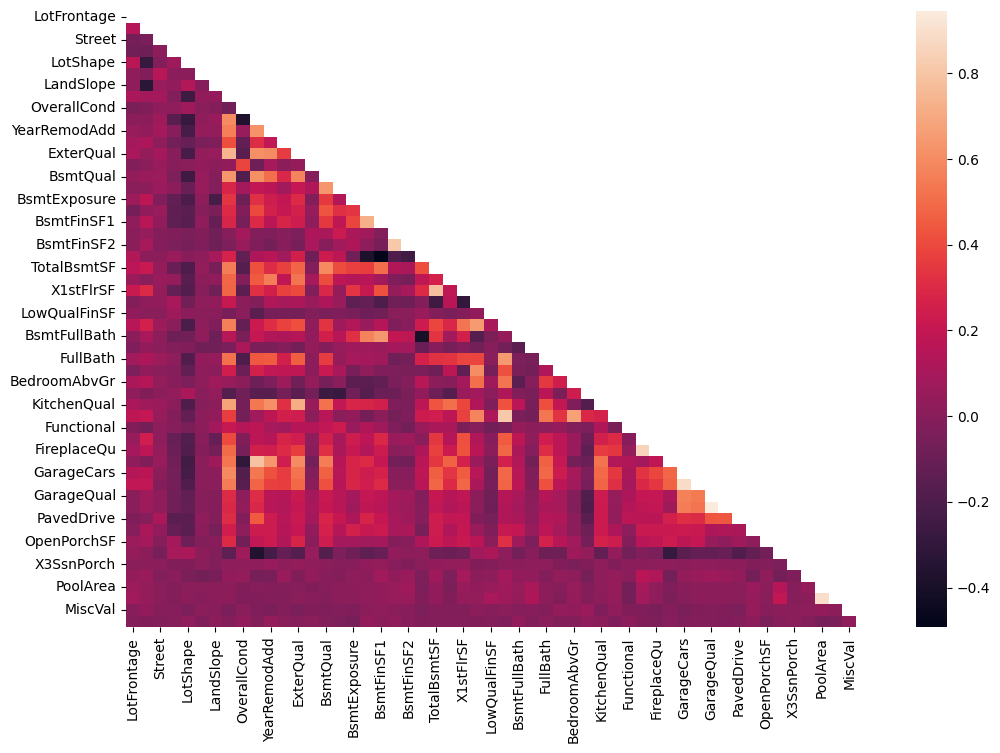

In [12]:
import seaborn as sns


corr_matrix = X_train_num.corr()
# remove upper triangle, to plot only lower triangle of correlations
corr_matrix = corr_matrix.where(~np.triu(np.ones(corr_matrix.shape)).astype(bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix)

Na oko nie ma tutaj wielu bardzo mocnych korelacji, rzędu 0.8 albo więcej. Mamy jednak dużo cech, więc warto popatrzeć też na same pary korelacji między kolumnami.

Tutaj liczy się ogólna siła korelacji, więc posortujemy malejąco po wartości bezwzględnej korelacji.

In [13]:
(corr_matrix.stack().sort_values(ascending=False, key=lambda x: abs(x)).head(10))

GarageCond    GarageQual      0.945034
PoolQC        PoolArea        0.899771
GarageArea    GarageCars      0.885777
FireplaceQu   Fireplaces      0.856795
TotRmsAbvGrd  GrLivArea       0.813288
BsmtFinSF2    BsmtFinType2    0.812546
GarageYrBlt   YearBuilt       0.791373
X1stFlrSF     TotalBsmtSF     0.780180
ExterQual     OverallQual     0.740265
BsmtFinSF1    BsmtFinType1    0.722830
dtype: float64

Jak widać, mamy jedną mocno skorelowaną parę - jakość i stan garażu. Ma to sens, w końcu to praktycznie zduplikowana informacja. Mamy też kilka par cech z dość mocnymi korelacjami powyżej 0.8. Ale biorąc pod uwagę, jak dużo cech mamy, to jest generalnie nieźle.

Ostatnią prostą miarą, którą zweryfikujemy, jest korelacja (konkretnie Pearson r correlation) między cechą a zmienną zależną. Scikit-learn implementuje ją jako funkcję, która przyjmuje macierz X, wektor y i zwraca wektor z wartością korelacji dla każdej cechy.

<Axes: >

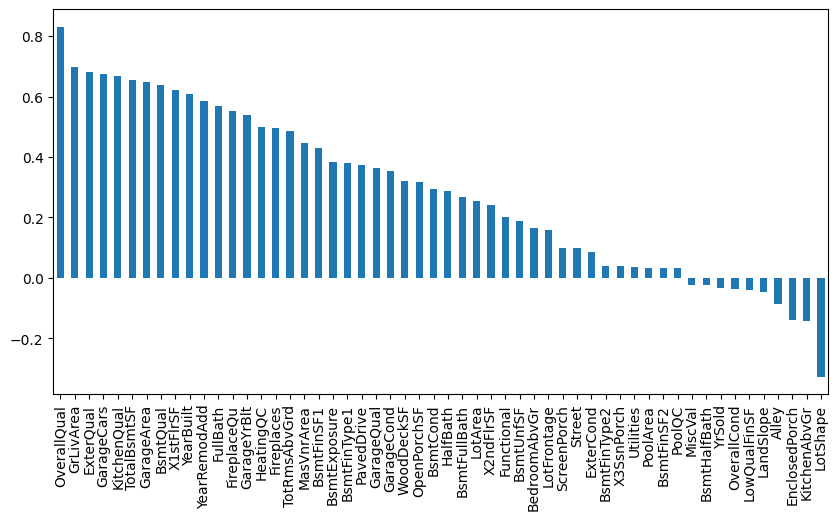

In [14]:
from sklearn.feature_selection import r_regression


importances_corr_r = r_regression(X_train_num, y_train)

# change to pd.Series for easier sorting and plotting
importances_corr_r = pd.Series(importances_corr_r, index=X_train_num.columns)
importances_corr_r = importances_corr_r.sort_values(ascending=False)

# create bar plot
importances_corr_r.plot.bar(figsize=(10, 5))

**Zadanie 2 (1 punkt)**

1. Czy uzyskane korelacje dla cech są zgodne z oczekiwaniami i ogólnie mają sens?
2. Mamy sporo cech o dość mocnej korelacji (0.5 lub więcej) - czy dobrze, czy źle, i dlaczego?
3. Mamy cechę (LotShape) o wyraźniej negatywnej korelacji. Czy takie cechy są użyteczne?

## Komentarz

1. Ekstremalne wartości są istotne, natomiast cechy o wartościach pośrednich pokrywają się z wcześniejszym wykresem, co wskazuje na niewielką korelację i tym samym ich małą znaczącość.

2. Dobrze. Wartości te mają istotny wpływ na wartość końcową.

3. Silna negatywna korelacja również wskazuje na znaczący wpływ danej cechy, ale w przeciwnym kierunku.

Przydałoby się w końcu przestać ignorować cechy kategoryczne i sprawdzić ważność faktycznie wszystkich cech. Można do tego użyć mutual information. Scikit-learn implementuje je jako funkcję, która przyjmuje X, y oraz informację o tym, które cechy są dyskretne. Mogą to być i cechy kategoryczne, i numeryczne, które mają wartości całkowite.

Mamy jednak problem - na wejściu mamy zmienne dyskretne, które zamieniliśmy na ciągłe przez min-max scaling. W przypadku mutual information nie należy tego robić, bo obsługuje wprost zmienne dyskretne.

**Zadanie 3 (3 punkty)**

1. Znajdź typy kolumn w danych:
   - kategoryczne: wszystkie typu "object"
   - numeryczne: wszystkie poza typem "object"
2. Stwórz pipeline do przetwarzania danych:
   - skorzystaj z klasy `ColumnTransformer`, przetwarzając w odpowiedni sposób zmienne (jak na laboratorium 1)
   - `OrdinalEncoder` do zmiennych kategorycznych, żeby zakodować je jako liczby całkowite
   - `SimpleImputer` do zmiennych numerycznych, aby imputować wartości brakujące medianą
   - użyj opcji `verbose_feature_names_out=False`, aby nazwy zmiennych nie były modyfikowane
3. Przetransformuj macierz `X_train`, tworząc `X_train_mi`.
4. Popraw z powrotem typy z pomocą metody `.convert_dtypes()` ([dokumentacja](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html)) - zapewni to, że zmienne całkowitoliczbowe będą miały odpowiedni typ.
5. Oblicz wartości mutual information dla zmiennych. Pamiętaj o podaniu, które zmienne są dyskretne, oraz o przekazaniu `random_state=0`.
6. Przedstaw ważności cech według MI na wykresie, posortowane malejąco.
7. Dokonaj interpretacji cech:
   - Czy nienadzorowane miary, których użyliśmy wcześniej (wariancja i korelacja) zgadzają się ważnością cech z MI?
   - Czy MI i korelacja ze zmienną zależną zgadzają się ze sobą? Jeżeli nie, to której mierze można by zaufać bardziej?
   - Czy mamy tutaj cechy, które wyraźnie warto usunąć wedle miary MI? Czy ma to sens, patrząc na znaczenie tych cech?

<Axes: >

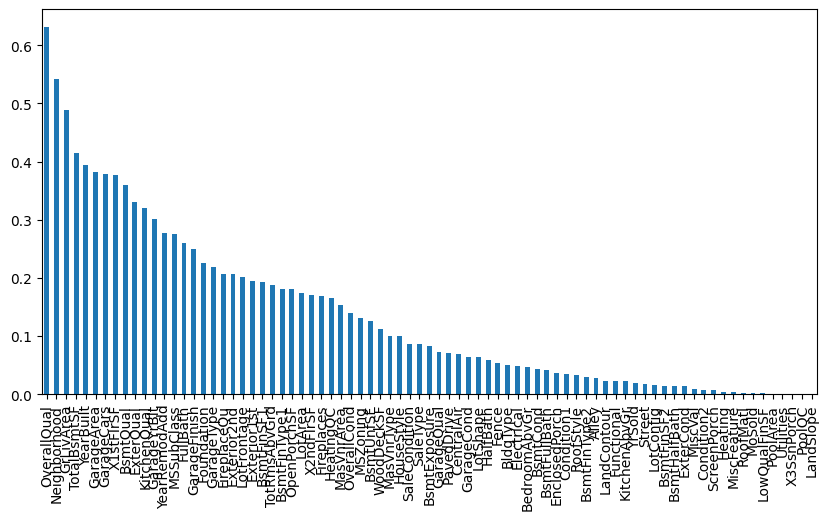

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns

# Create a pipeline for data preprocessing
column_transformer = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", SimpleImputer(strategy="median"), numerical_features),
    ],
    verbose_feature_names_out=False,
)

column_transformer.fit(X_train)

# Transform the training data
X_train_mi = column_transformer.transform(X_train)

# Correct data types
X_train_mi = column_transformer.transform(X_train)

# Get boolean mask with discrete columns
discrete_features = X_train_mi.columns.isin(categorical_features)

# Calculate mutual information for the variables
importances_mi = mutual_info_regression(
    X_train_mi, y_train, discrete_features=discrete_features, random_state=0
)

# Plot the feature importances
importances_mi = pd.Series(importances_mi, index=X_train_mi.columns)
importances_mi = importances_mi.sort_values(ascending=False)

importances_mi.plot.bar(figsize=(10, 5))

## Komentarz

MI bliżej do zgoności z korelacją niż wariancją. Zarówno korelacja jak i MI, wskazują na niskie znaczenie cech takich jak "Utilities" czy "LandSlope". Z tego powodu rozważa się możliwość ich usunięcia.

Na obecnym etapie widać, że co najmniej kilka cech można by wyeliminować z naszego zbioru, a pewien zbiór wyraźnie dominuje. Używaliśmy jednak tylko metod typu filter. Wypróbujmy jeszcze metody typu embedded i wrapper.

Najpopularniejsze metody embedded to regresja liniowa i las losowy. Zgodnie z wynikami z laboratorium 1 użyjemy ridge regression (z regularyzacją L2), żeby zminimalizować przeuczenie. Co ważne, trzeba sprawdzić, czy te metody uzyskują dobre wyniki i czy nie przeuczają - metody embedded i wrapper wymagają dobrych modeli, aby dobrze oceniać ważność cech.

Pewną wadą tych metod w kontekście tego zbioru jest to, że nie działają dla zmiennych kategorycznych i musimy dokonać one-hot encodingu. Otrzymamy więcej zmiennych i trochę inne informacje o ważności cech - może się na przykład okazać, że tylko 1 czy 2 wartości dla zmiennej kategorycznej są mało ważne. To także przydatna informacja, bo można wtedy na przykład gromadzić mniej kategorii w przyszłości.

In [17]:
from sklearn.preprocessing import OneHotEncoder


categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns

categorical_pipeline = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

column_transformer = ColumnTransformer(
    [
        ("cat_pipeline", categorical_pipeline, categorical_features),
        ("num_pipeline", numerical_pipeline, numerical_features),
    ],
    verbose_feature_names_out=False,
)
column_transformer.fit(X_train)

X_train_processed = column_transformer.transform(X_train)
X_test_processed = column_transformer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_train_dollars = np.expm1(y_train)
    y_test_dollars = np.expm1(y_test)

    y_pred_train_dollars = np.expm1(y_pred_train)
    y_pred_test_dollars = np.expm1(y_pred_test)

    rmse_train_dollars = mean_squared_error(
        y_train_dollars, y_pred_train_dollars, squared=False
    )
    rmse_test_dollars = mean_squared_error(
        y_test_dollars, y_pred_test_dollars, squared=False
    )

    print(f"Train RMSE: {rmse_train_dollars:.2f}$")
    print(f"Test RMSE: {rmse_test_dollars:.2f}$")

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge


reg_linear = LinearRegression(fit_intercept=False)
reg_linear.fit(X_train_processed, y_train)

reg_ridge = Ridge(random_state=0)
reg_ridge.fit(X_train_processed, y_train)

reg_rf = RandomForestRegressor(random_state=0)
reg_rf.fit(X_train_processed, y_train)

print("Linear regression")
assess_regression_model(
    reg_linear, X_train_processed, X_test_processed, y_train, y_test
)
print()
print("Ridge regression")
assess_regression_model(reg_ridge, X_train_processed, X_test_processed, y_train, y_test)
print()
print("Random Forest regression")
assess_regression_model(reg_rf, X_train_processed, X_test_processed, y_train, y_test)

Linear regression
Train RMSE: 16754.99$
Test RMSE: 21321.44$

Ridge regression
Train RMSE: 16873.34$
Test RMSE: 18880.55$

Random Forest regression
Train RMSE: 9520.31$
Test RMSE: 25880.46$


Co ciekawe, w przypadku tego zbioru modele liniowe dają lepsze wyniki od złożonego lasu losowego! Może być to kwestia rozmiaru danych, lub po prostu potrzeby tuningu hiperparametrów. Trzeba jednak zauważyć, że każdy z modeli przeucza, nawet ridge regression, a selekcja cech redukuje overfitting dzięki usuwaniu szumu w danych.

W takim wypadku ewidentnie lepiej jest oprzeć się na ważności cech z modeli liniowych. Są to po prostu wagi z atrybutu `.coef_`. Jako że cech po one-hot encodingu jest bardzo dużo, to narysujemy wykres tylko dla najlepszych cech.

Cechy o wadze poniżej 0.01 można uznać za naprawdę słabe, bo mają minimalną wagę. Sprawdzimy, ile ich jest, oraz jakie są najmniej ważne według regresji liniowej cechy.

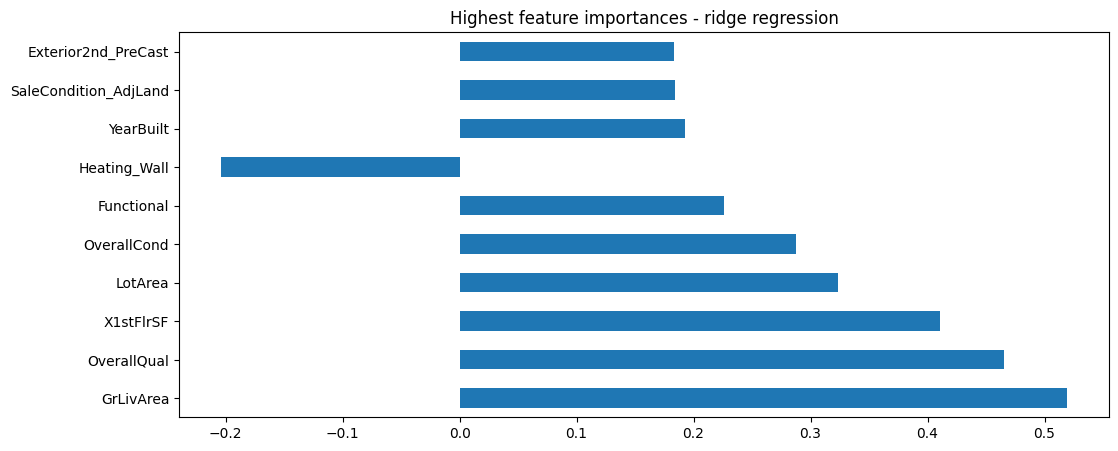

Number of features with weight <= 0.01: 55
This is 23.61% of all features
Features with lowest weights:


Exterior2nd_ImStucc   -0.001868
MSSubClass_SC180       0.001732
FireplaceQu           -0.001538
Exterior2nd_HdBoard   -0.001393
MoSold_Sep             0.001337
GarageFinish_Unf      -0.001316
MSSubClass_SC40        0.001219
Exterior1st_ImStucc    0.001120
MoSold_Dec             0.000814
Neighborhood_Sawyer   -0.000329
dtype: float64

In [20]:
importances_ridge = reg_ridge.coef_

# change to pd.Series for easier sorting and plotting
importances_ridge = pd.Series(importances_ridge, index=X_train_processed.columns)
importances_ridge = importances_ridge.sort_values(ascending=False, key=lambda x: abs(x))

# create horizontal bar plot for best features
importances_ridge.head(10).plot.barh(
    title="Highest feature importances - ridge regression", figsize=(12, 5)
)
plt.show()

# print number of very low weight features
num_low_weight_features = (importances_ridge.abs() <= 0.01).sum()
print("Number of features with weight <= 0.01:", num_low_weight_features)
print(
    f"This is {100 * num_low_weight_features / len(importances_ridge):.2f}% of all features"
)

print("Features with lowest weights:")
importances_ridge.tail(10)

Prawie 1/4 naszych cech ma praktycznie zerowy wpływ na predykcje regresji liniowej! Oczywiście w sumie ten wpływ może być całkiem spory, ale warto zauważyć, że jeżeli chcielibyśmy ostro redukować ilość zbieranych cech, np. ze względu na koszty przechowywania albo wymagania prawne, to jesteśmy w stanie to zrobić i prawdopodobnie nie obniży to bardzo wyników naszego modelu. Pamiętajmy też, że regresja liniowa skaluje się gorzej z liczbą cech, niż z liczbą próbek, więc tutaj różnica w szybkości może być faktycznie zauważalna.

Na koniec zostały nam metody typu wrapper. Do analizy cech szczególnie interpretowalne jest permutation feature importance, dlatego go teraz użyjemy. Ze względu na to, że nasz zbiór jest mały, użyjemy wersji z walidacją skrośną.

**Zadanie 4 (2 punkty)**

1. Stwórz obiekt `KFold` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), dzieląc zbiór treningowy na 5 foldów do walidacji skrośnej.
2. W pętli dla kolejnych foldów:
   1. Wytnij ze zbioru treningowego podzbiór treningowy i walidacyjny, odpowiadający danemu foldowi (patrz przykład w dokumentacji).
   2. Wytrenuj ridge regression na stworzonym podzbiorze treningowym.
   3. Oblicz permutation feature importance ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)) na zbiorze walidacyjnym:
      - jako metryki (`scoring`) użyj stworzonego poniżej `rmse`
      - użyj 100 powtórzeń
      - pamiętaj o `random_state=0`
      - może się przydać `n_jobs=-1`
      - wyciągnij średnie ważności (`importances_mean`) z wynikowej struktury
   4. Dopisz ważność do listy (tak, żeby każdy fold dał 1 wynik walidacyjny).
3. Oblicz średnią ważność z foldów (mogą się przydać `np.vstack()` i `np.mean()` z odpowiednią osią).
4. Narysuj wykres słupkowy 10 najważniejszych cech według permutation importance.
5. Sprawdź, czy są cechy, które nie wpłynęły na wynik, tj. praktycznie nie różnią się od zera (przyda się `np.isclose()`). Jeżeli tak, to wypisz, ile ich jest i jaki procent liczby cech stanowią.
6. Skomentuj:
   - czy cechy pokrywają się z tym, co widzieliśmy do tej pory?
   - czy było warto obliczać taki feature importance, czy wnioski z samej metody embedded były wystarczające?

In [21]:
from sklearn.metrics import make_scorer


rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

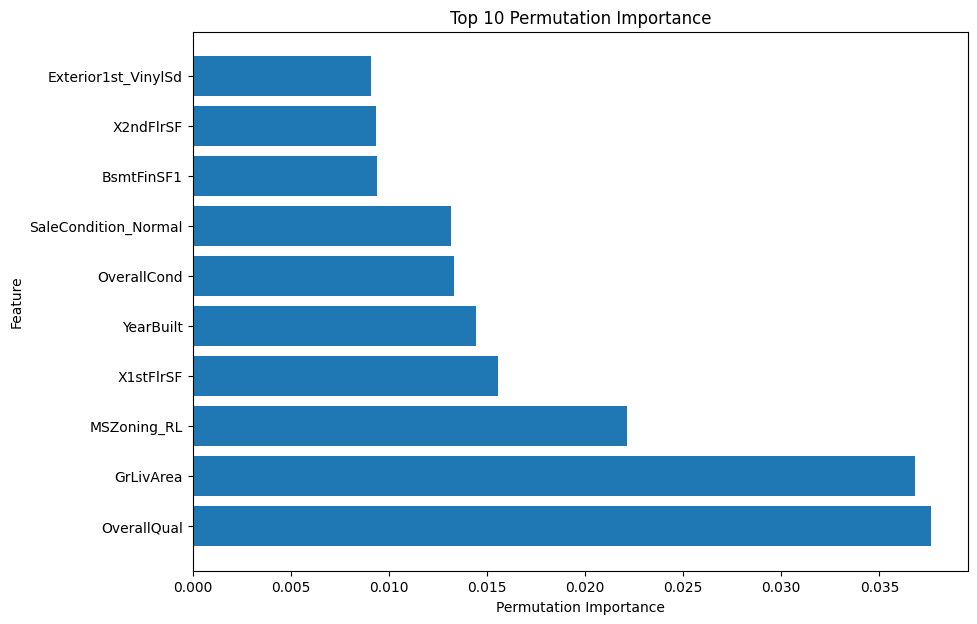

There are 16 features that have practically zero impact on the predictions.
They account for 6.866952789699571% of the total number of features.


In [22]:
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

# Create KFold object
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Accumulate validation permutation importance scores
scores = []

# Iterate through fold indexes
for train_index, valid_index in kfold.split(X_train_processed):
    # Create X_train_fold, X_valid_fold, y_train_fold, and y_valid_fold using indexes
    X_train_fold, X_valid_fold = (
        X_train_processed.iloc[train_index],
        X_train_processed.iloc[valid_index],
    )
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Train ridge regression
    reg_ridge_fold = Ridge(random_state=0)
    reg_ridge_fold.fit(X_train_fold, y_train_fold)

    # Calculate permutation importance
    result = permutation_importance(
        reg_ridge_fold,
        X_valid_fold,
        y_valid_fold,
        scoring=rmse,
        n_repeats=100,
        random_state=0,
        n_jobs=-1,
    )

    # Extract mean importance and append to scores
    scores.append(result.importances_mean)

# Stack and calculate mean importances
importances_mean = np.mean(np.vstack(scores), axis=0)
feature_indices = np.arange(len(importances_mean))
sorted_indices = np.argsort(importances_mean)[::-1]

# Plot the top 10 most important features based on permutation importance
plt.figure(figsize=(10, 7))
plt.barh(feature_indices[:10], importances_mean[sorted_indices][:10])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importance")
plt.yticks(feature_indices[:10], X_train_processed.columns[sorted_indices][:10])
plt.show()

# Check unimportant features
unimportant_features = np.sum(np.isclose(importances_mean, 0))
percentage_unimportant = (unimportant_features / len(X_train_processed.columns)) * 100

print(
    f"There are {unimportant_features} features that have practically zero impact on the predictions."
)
print(f"They account for {percentage_unimportant}% of the total number of features.")

## Komentarz

Wyniki w dużej mierze się pokrywają, dlatego raczej nie jest sensowne poświęcać dużo czasu na to.

Dokonaliśmy już wielu analiz i wiemy sporo o naszych cechach. Na cele analityczne tak naprawdę tyle by wystarczyło - możemy skupić się na niektórych, inne usunąć. Ta część to tak naprawdę business intelligence (BI), gdzie w tym wypadku skorzystaliśmy z uczenia maszynowego do głębszej analizy danych.

Teraz czas przejść do zastosowania selekcji cech w samym ML i budowaniu modeli predykcyjnych.

## Selekcja cech

Wykorzystamy teraz posiadane informacje, żeby dokonać selekcji cech.

Co do surowych, wejściowych cech wiemy, że:
- `Utilities` ma bardzo niską wariancję
- `GarageCond` i `GarageQual` są bardzo skorelowane
- jest szereg cech o praktycznie zerowej wartości wedle mutual information

To ostatnie będzie też zachodzić po one-hot encodingu - jeżeli cecha na wejściu jest bezużyteczna, to tym bardziej będzie bezużyteczna, kiedy potniemy ją na więcej cech. Możemy więc tego bezpiecznie dokonać.

**Zadanie 5 (2 punkty)**

Stwórz pipeline do przetwarzania zmiennych. Do usuwania kolumn użyj stworzonej poniżej klasy `DropFeatures`.

Kroki to po kolei:
1. `DropFeatures`, które usuwa kolumny `Utilities` i `GarageCond`
2. `ColumnTransformer`, który:
   - dla cech kategorycznych robi `OneHotEncoder`, pamiętaj o `drop="first", sparse_output=False, handle_unknown="ignore"`
   - dla cech numerycznych robi pipeline `SimpleImputer` oraz `MinMaxScaler`
   - użyj opcji `verbose_feature_names_out=False`, aby nazwy zmiennych nie były modyfikowane nazwą pipeline'
3. Selekcja cech z użyciem `SelectPercentile` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html)), aby usunąć 10% najsłabszych cech według mutual information. Jako funkcję do obliczania wyniku wykorzystaj mutual information. Uwaga: musisz ręcznie stworzyć `score_func`, żeby podać `random_state=0`, stworzono taki obiekt poniżej.

Przetransformowane `X_train` i `X_test` zapisz w zmiennych `X_train_preproc` i `X_test_preproc`.

**Uwaga:** przy tworzeniu listy zmiennych numerycznych pamiętaj, żeby usunąć z niej nazwy usuwanych kolumn, tj. `Utilities` i `GarageCond`.

In [23]:
class DropFeatures:
    def __init__(self, features: str | list[str]):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.features)

In [24]:
from sklearn.feature_selection import mutual_info_regression


scorer_mi = lambda X, y: mutual_info_regression(X, y, random_state=0)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectPercentile

categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns
numerical_features = numerical_features.drop(["Utilities", "GarageCond"])

pipeline = Pipeline(
    [
        ("drop_features", DropFeatures(["Utilities", "GarageCond"])),
        (
            "column_transformer",
            ColumnTransformer(
                [
                    (
                        "cat_pipeline",
                        OneHotEncoder(
                            drop="first", sparse=False, handle_unknown="ignore"
                        ),
                        categorical_features,
                    ),
                    (
                        "num_pipeline",
                        Pipeline(
                            [
                                ("imputer", SimpleImputer(strategy="median")),
                                ("scaler", MinMaxScaler()),
                            ]
                        ),
                        numerical_features,
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        (
            "feature_selection",
            SelectPercentile(score_func=mutual_info_regression, percentile=90),
        ),
    ]
)

# Fit and transform the training data
X_train_preproc = pipeline.fit_transform(X_train, y_train)

# Transform the test data
X_test_preproc = pipeline.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mamy teraz pełen zestaw cech, gotowy do treningu regresji liniowej.

In [26]:
reg_ridge = Ridge(random_state=0)
reg_ridge.fit(X_train_preproc, y_train)

assess_regression_model(reg_ridge, X_train_preproc, X_test_preproc, y_train, y_test)

Train RMSE: 17074.83$
Test RMSE: 18978.26$


Wynik testowy jest bardzo podobny, natomiast błąd treningowy jest większy. Czy to gorzej? Otóż niekoniecznie - w końcu teraz przeuczamy mniej. Taki model może być mniej podatny na szum i błędne pomiary, dając bardziej pewne (robust) wyniki w przyszłości.

Nie wykorzystaliśmy jednak jeszcze ważnej metody selekcji cech - Recursive Feature Elimination (RFE).

**Zadanie 6 (1 punkt)**

1. Zastosuj RFECV ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)) do selekcji cech:
   - użyj ridge regression jako estymatora bazowego
   - wybierz co najmniej 80% oryginalnych cech
   - zastosuj 10-krotną walidację skrośną
   - pamiętaj o `random_state=0`
   - może się przydać `n_jobs=-1`
2. Przetransformuj `X_train_preproc` i `X_test_preproc`, tworząc `X_train_reduced` i `X_test_reduced`. Sprawdź, ile cech usunięto.
3. Wytrenuj ridge regression na zredukowanych cechach.
4. Sprawdź wyniki na zbiorze treningowym i testowym (skorzystaj z `assess_regression_model`).

In [27]:
from sklearn.feature_selection import RFECV

# Apply RFECV for feature selection
selector = RFECV(
    estimator=reg_ridge,
    min_features_to_select=int(0.8 * X_train_preproc.shape[1]),
    cv=10,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)
selector.fit(X_train_preproc, y_train)

# Transform the data with reduced features
X_train_reduced = selector.transform(X_train_preproc)
X_test_reduced = selector.transform(X_test_preproc)

# Get the number of removed features
num_removed_features = X_train_preproc.shape[1] - X_train_reduced.shape[1]
print("Number of removed features:", num_removed_features)

# Train the Ridge regression model on the reduced features
reg_ridge_reduced = Ridge(random_state=0)
reg_ridge_reduced.fit(X_train_reduced, y_train)

# Evaluate the model on the training and test sets
assess_regression_model(
    reg_ridge_reduced, X_train_reduced, X_test_reduced, y_train, y_test
)

Number of removed features: 42
Train RMSE: 17100.63$
Test RMSE: 18897.84$


Sumarycznie wyeliminowaliśmy sporo cech, a nasz model uzyskuje wyniki bardzo podobne do wyjściowych. Być może uda nam się zyskać jeszcze więcej, jeżeli użyjemy redukcji wymiarowości.

## Redukcja wymiarowości

Mamy dużo cech rzadkich po one-hot encodingu, ponad 100. Redukcja takich cech to typowe zadanie dla SVD, które liniowo zredukuje te cechy z powrotem do mniejszej liczby cech gęstych. W scikit-learn jest ono zaimplementowane w klasie `TruncatedSVD`, która jako swój główny argument przyjmuje `n_compoments`, czyli liczbę docelowych cech. Dla uproszczenia przyjmiemy 60, czyli około połowy cech rzadkich po one-hot encodingu.

**Zadanie 7 (0.5 punktu)**

Skopiuj pipeline z zadania 5, dodając `TrucatedSVD` do pipeline'u dla zmiennych kategorycznych, z `n_components=60` i `random_state=0`. Wytrenuj ridge regression na wynikowych cechach i zmierz wynik. Czy udało się go poprawić?

In [28]:
from sklearn.decomposition import TruncatedSVD

pipeline = Pipeline(
    [
        ("drop_features", DropFeatures(["Utilities", "GarageCond"])),
        (
            "column_transformer",
            ColumnTransformer(
                [
                    (
                        "cat_pipeline",
                        Pipeline(
                            [
                                (
                                    "one_hot",
                                    OneHotEncoder(
                                        drop="first",
                                        sparse=False,
                                        handle_unknown="ignore",
                                    ),
                                ),
                                ("svd", TruncatedSVD(n_components=60, random_state=0)),
                            ]
                        ),
                        categorical_features,
                    ),
                    (
                        "num_pipeline",
                        Pipeline(
                            [
                                ("imputer", SimpleImputer(strategy="median")),
                                ("scaler", MinMaxScaler()),
                            ]
                        ),
                        numerical_features,
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        (
            "feature_selection",
            SelectPercentile(score_func=mutual_info_regression, percentile=90),
        ),
    ]
)

pipeline.fit(X_train, y_train)

X_train_preproc = pipeline.transform(X_train)

X_test_preproc = pipeline.transform(X_test)

# Train the Ridge regression model on the reduced features
reg_ridge_svd = Ridge(random_state=0)
reg_ridge_svd.fit(X_train_preproc, y_train)

# Evaluate the model on the training and test sets
assess_regression_model(reg_ridge_svd, X_train_preproc, X_test_preproc, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train RMSE: 18671.59$
Test RMSE: 19110.73$


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Komentarz

Udało się poprawić wynik.

Na koniec wykorzystamy najpopularniejszą metodę redukcji wymiaru, czyli PCA. Jako że nasze cechy przeszły już tyle czyszczenia i redukcji, to nie ma raczej sensu ich dalsza obróbka. Zamiast tego możemy je zrzutować do 2D - jeżeli wizualizacja będzie dobrej jakości, i będzie pokrywać się z naszą intuicją, to znaczy, że mamy dobry zestaw cech.

**Uwaga:** poniższy kod zakłada, że cechy po transformacji z ostatniego zadania są w zmiennej `X_train_preproc`.

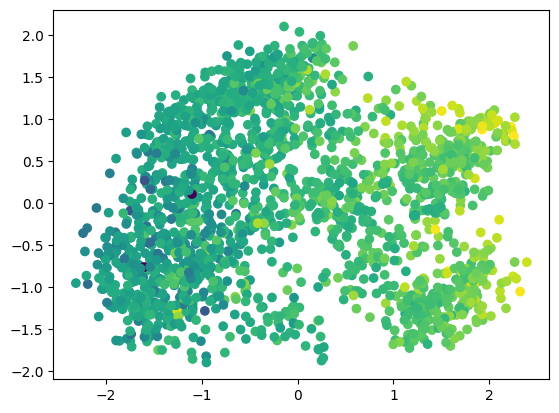

In [29]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2, random_state=0)
pca.fit(X_train_preproc)


X_train_embed = pca.transform(X_train_preproc)
X_train_embed = X_train_embed.values

plt.scatter(X_train_embed[:, 0], X_train_embed[:, 1], c=y_train)

Jak widać, nawet po ekstremalnej liniowej redukcji do 2D nasze dane zachowują w miarę strukturę, z większymi (jaśniejszymi) wartościami po prawej, i mniejszymi (ciemniejszymi), w prawym dolnym rogu. Jeżeli liniowa redukcja dobrze działa, to znaczy, że wejściowe cechy były na tyle dobre, że nawet ich liniowa kombinacja zachowuje dużo informacji.

Takie wykresy są często nieco bardziej informatywne w przypadku klasyfikacji, gdzie dodatkowo możemy obserwować klastry formowane przez klasy, ale nawet przy tej regresji widać, że efekty są całkiem sensowne.